# Logistic Regression

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import os
import tqdm
from tqdm import notebook

## Loading Data

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
PARENT = '/gdrive/MyDrive/Projects/ML_Models/'

In [4]:
%cd /gdrive/MyDrive/Projects/ML_Models/

/gdrive/MyDrive/Projects/ML_Models


In [5]:
df =  pd.read_csv('dataset_LR.csv')

In [6]:
df.head()

,attr1,attr2,attr3,attr4,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


## Model

In [9]:
class LogReg():

    def __init__(self, df, standardize=False, train_size=0.7, randomize=True):
        self.w = None
        self.b = None
        self.df = df
        self.train_size = train_size
        self.randomize = randomize
        self.standardize = standardize
        self.X_train, self.X_test, self.y_train, self.y_test = self.train_test_split()
        if standardize:
            self.standard()
    
    def train_test_split(self):
        '''
        Randomizes the data and Splits the data points into training and testing values in the ratio given.
        '''
        data = np.array(self.df)
        train_size=self.train_size
        
        if self.randomize:
            np.random.shuffle(data)

        X = data[:,:-1]
        y = data[:,-1]

        train = int(train_size * X.shape[0])
        test = int((1-train_size) * X.shape[0])

        X_train = X[0 : train]
        X_test = X[train : train+test] 
        y_train = y[0 : train]
        y_test = y[train : train+test] 

        return X_train, X_test, y_train, y_test

    def standard(self):
        '''
        Standardizes the given data.
        '''
        self.X_train = (self.X_train - self.X_train.mean(axis=0)) / self.X_train.std(axis=0)
        self.X_test = (self.X_test - self.X_train.mean(axis=0)) / self.X_train.std(axis=0)  
  
    def perceptron(self, X):
        '''
        Evaluates the linear combination of the weights and the training data.
        Parameters:
            X: Training Point
        '''
        return np.dot(X, self.w.T) + self.b

    def sigmoid(self, X):
        '''
        Sigmoid Function.
        Parameters:
            X: Training Point
        '''
        return 1.0 / (1.0 + np.exp(-X))

    def grad_w(self, x, y):
        '''
        Calculates the gradient of the weight values.
        Parameters:
            x: Training point
            y:  
        '''
        y_pred = self.sigmoid(self.perceptron(x))
        return (y_pred - y) * y_pred * (1 - y_pred) * x
  
    def grad_b(self, x, y):
        '''
        Calculates the gradient of x_0 value.
        Parameters:
            x: 
            y: 
        '''
        y_pred = self.sigmoid(self.perceptron(x))
        return (y_pred - y) * y_pred * (1 - y_pred)

    def mean_squared_error(self, y_pred, y):
        '''
        Evaluates the Mean Squared error of the predicted values by comparing it with the true values.
        Parameters:
            y_pred: Predicted values.
            y: True output values.
        '''
        return sum([(y1-y2)**2 for y1, y2 in zip(y, y_pred)])/len([(y1-y2)**2 for y1, y2 in zip(y, y_pred)])
    
    def accuracy(self, y_pred, y):
        '''
        Calculates the accuracy score of the predicted values.
        Parameters:
            y_pred: Predicted values.
            y: True output values.
        '''
        correct = 0
        for i in range(y.shape[0]):
            if y_pred[i]>0.5:
                yp=1
            else:
                yp=0
            if y[i] == yp:
                correct += 1
        return correct / float(y.shape[0])

    def fit(self, X, Y, epochs = 1, learning='GD', learning_rate = 1, batch_size=1, intialize = False, display_loss=False):
        '''
        Trains the model either using Gradient Descent or Stochastic Gradient Descent.
        Parameters:
            X: testing sample
        '''
    
        #intialize
        if intialize:
            self.w = np.random.randn(1, X.shape[1])
            self.b = 0

        if display_loss:
            loss={}
            accuracy={}

        for i in tqdm.notebook.tqdm(range(epochs), total=epochs, unit="epoch"):
            dw = 0
            db = 0

            if learning == 'GD':
                for x, y in zip(X, Y):
                    dw += self.grad_w(x,y)
                    db += self.grad_b(x,y)
                self.w -= learning_rate * dw
                self.b -= learning_rate * db

            if learning == 'SGD':
                for j in range(X.shape[0]):
                    randInt = np.random.randint(0,X.shape[0])
                    x = X[randInt, :]
                    y = Y[randInt]
                    dw += self.grad_w(x,y)
                    db += self.grad_b(x,y)
                self.w -= learning_rate * dw
                self.b -= learning_rate * db

            if display_loss:
                Y_pred = self.sigmoid(self.perceptron(X))
                loss[i] = self.mean_squared_error(Y_pred,Y)[0]
                accuracy[i] = self.accuracy(Y_pred,Y)
                if i%50==0:
                    print('Epoch:', i,'Loss:', loss[i],'Accuracy:', accuracy[i])

        if display_loss:
            plt.subplot(2, 1, 1)
            plt.plot(list(loss.values()))
            plt.xlabel('Epochs')
            plt.ylabel('Mean Squared Error')

            plt.subplot(2, 1, 2)
            plt.plot(list(accuracy.values()))
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            
            plt.show()

    def predict(self, X):
        '''
        Evaluates the sigmoid function value of the given data.
        Parameters:
            X: testing sample
        '''
        Y_pred = []
        for x in X:
            y_pred = self.sigmoid(self.perceptron(x))
            Y_pred.append(y_pred)
        return np.array(Y_pred)
    
    def binarize(self, X, threshold=0.5):
        '''
        Evaluates the binary labels of the given data.
        Parameters:
            X: testing sample
        '''
        y_pred = self.predict(X)
        Y_p = []
        for y in range(y_pred.shape[0]):
            if y_pred[y]>threshold:
                Y_p+=[1]
            else:
                Y_p+=[0]
        return np.array(Y_p)

    def evaluate(self, x_test, y_test):
        '''
        Evaluates the model for a given testing data
        Parameters:
            x_test: testing samples
            y_test: testing labels
        '''

        y_pred = self.binarize(x_test)
        dict = self.report(y_pred, y_test)
        print('Classification Report') 
        n = np.array(list(dict.items()))
        df = pd.DataFrame(n[:,1], index=n[:,0], columns=[''])
        print(df)
        self.confusion_matrix(dict)

    def cross_val(self, k, epochs=2000, learning_rate=0.015):
        '''
        Performs k-fold validation on the given data.  
        Parameters:
            data
            k: No. of folds
        '''
        
        TP, TN, FP, FN, Total, accuracy, recall, precision=0, 0, 0, 0, 0, 0, 0, 0

        print('Total of 10 Splits:')        
        for i in range(k):
            
            print('Split', i+1,': ')
            X_train, X_test, Y_train, Y_test = self.train_test_split()  
            if self.standardize:
                self.standard()
                
            print('Training the Model...')
            self.fit(X_train, Y_train, epochs, learning_rate=learning_rate , intialize = True, display_loss=True)
            print('Trained the Model.')

            y_pred = self.binarize(X_test)            
            metric_dict = self.report(y_pred, Y_test)
            print('The most important feature is \'attr', np.argmax(self.w), '\'','with weight', self.w[0][np.argmax(self.w)])
            
            TP+=metric_dict['TP']
            TN+=metric_dict['TN']
            FP+=metric_dict['FP']
            FN+=metric_dict['FN']
            Total+=metric_dict['Total']
            accuracy+=metric_dict['Accuracy']
            precision+=metric_dict['Precision']
            recall+=metric_dict['Recall']
            
            self.evaluate(X_test, Y_test)
        
        avg = {'TP':TP/k, 'TN':TN/k, 'FP':FP/k, 'FN':FN/k, 'Total':Total/k, 'Accuracy':accuracy/k, 'Recall':recall/k, 'Precision':precision/k}
        
        print('Final Classification Report') 
        n = np.array(list(avg.items()))
        df = pd.DataFrame(n[:,1], index=n[:,0], columns=[''])
        print(df)
        self.confusion_matrix(avg)
    
    def report(self, y_pred, y_test):
        '''
        calculates precision and recall metrics
        Parameters:
            y_pred: predicted labels on a testing set
            y_test: true labels of the testing set
        '''
        
        TP=0
        TN=0
        FP=0
        FN=0
        Total=len(y_pred)
        for pred, test in zip(y_pred, y_test):
            if pred==test:
                if pred==0:
                    TN+=1
                else:
                    TP+=1
            else:
                if pred==1:
                    FP+=1
                else:
                    FN+=1
        
        accuracy = (TP+TN) / Total
        recall = TP / (TP+FN)
        precision = TP / (TP+FP)
        
        return {'TP':TP, 'TN':TN, 'FP':FP, 'FN':FN, 'Total':Total, 'Accuracy':accuracy, 'Recall':recall, 'Precision':precision}
        
    def confusion_matrix(self, report_val):
        '''
        Plots the confusion Matrix of the given data.
        '''
        
        fig, ax = plt.subplots()
        classes = ['Positive', 'Negitive']
        t = report_val['Total']
        report = np.array([[report_val['TN']/t, report_val['FP']/t], [report_val['FN']/t, report_val['TP']/t]])
        im = ax.imshow(report, cmap = 'Blues')

        ax.set_xticks(np.arange(len(classes)))
        ax.set_yticks(np.arange(len(classes)))

        ax.set_xticklabels(classes)
        ax.set_yticklabels(classes)


        plt.setp(ax.get_xticklabels(), rotation_mode="anchor")
        
        group_names = ['True Neg','False Pos', 'False Neg','True Pos']
        group_percentages = ['{0:.2%}'.format(value) for value in report.flatten()]

        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)

        for i in range(len(classes)):
            for j in range(len(classes)):
                text = ax.text(j, i, labels[i, j], ha="center", va="center")

        ax.set_title('Confusion Matrix', fontdict = {'size':18}, pad = 20)
        
        fig.tight_layout()
        plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
        plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
        plt.show()

## Gradient Descent

### Learning Rate = 0.015 and Epochs = 300 - Accuracy = 98.78% - No Standardization

In [17]:
GD = LogReg(df)

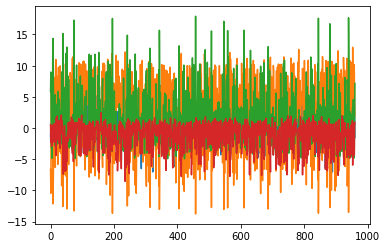

In [18]:
plt.plot(GD.X_train)

Total of 10 Splits:
Split 1 : 
Training the Model...


Epoch: 0 Loss: 0.14979708885923487 Accuracy: 0.821875
Epoch: 50 Loss: 0.010793596287493146 Accuracy: 0.9854166666666667
Epoch: 100 Loss: 0.011823561899831731 Accuracy: 0.9854166666666667
Epoch: 150 Loss: 0.009584580492064987 Accuracy: 0.9875
Epoch: 200 Loss: 0.009097268167660481 Accuracy: 0.9875
Epoch: 250 Loss: 0.007739893974698076 Accuracy: 0.990625



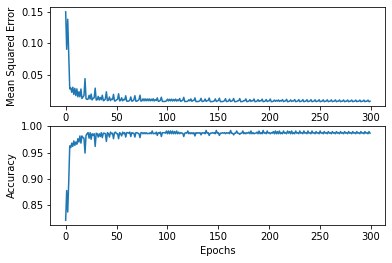

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.1824945029822651
Classification Report
                             
TP                        179
TN                        229
FP                          1
FN                          2
Total                     411
Accuracy   0.9927007299270073
Recall      0.988950276243094
Precision  0.9944444444444445


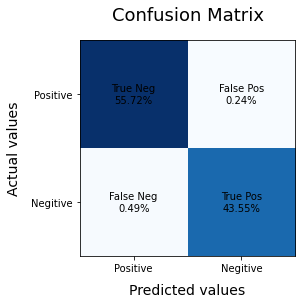

Split 2 : 
Training the Model...


Epoch: 0 Loss: 0.2280090135084348 Accuracy: 0.7229166666666667
Epoch: 50 Loss: 0.012216284644717171 Accuracy: 0.984375
Epoch: 100 Loss: 0.007537987889918494 Accuracy: 0.990625
Epoch: 150 Loss: 0.008460971780223616 Accuracy: 0.990625
Epoch: 200 Loss: 0.007439276639455037 Accuracy: 0.990625
Epoch: 250 Loss: 0.007273033568729973 Accuracy: 0.990625



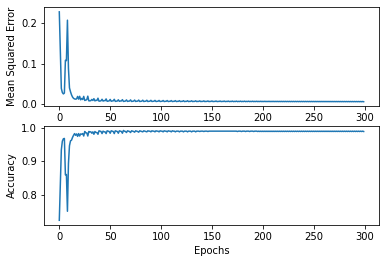

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.32422180404182055
Classification Report
                             
TP                        175
TN                        231
FP                          4
FN                          1
Total                     411
Accuracy   0.9878345498783455
Recall     0.9943181818181818
Precision  0.9776536312849162


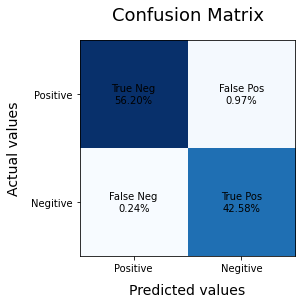

Split 3 : 
Training the Model...


Epoch: 0 Loss: 0.16928973233698072 Accuracy: 0.7583333333333333
Epoch: 50 Loss: 0.011979925882762359 Accuracy: 0.9833333333333333
Epoch: 100 Loss: 0.0078084335683543905 Accuracy: 0.9895833333333334
Epoch: 150 Loss: 0.007954970031190688 Accuracy: 0.9895833333333334
Epoch: 200 Loss: 0.0074638850994469845 Accuracy: 0.9895833333333334
Epoch: 250 Loss: 0.007166089362142204 Accuracy: 0.9895833333333334



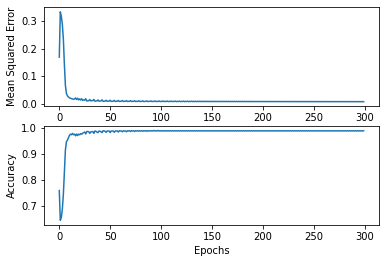

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.33646597666465855
Classification Report
                             
TP                        176
TN                        231
FP                          4
FN                          0
Total                     411
Accuracy   0.9902676399026764
Recall                    1.0
Precision  0.9777777777777777


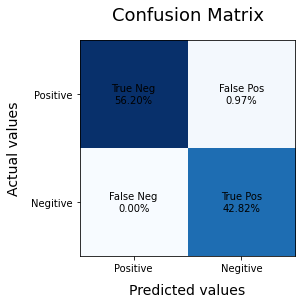

Split 4 : 
Training the Model...


Epoch: 0 Loss: 0.1403212968034932 Accuracy: 0.821875
Epoch: 50 Loss: 0.009671804660683351 Accuracy: 0.9895833333333334
Epoch: 100 Loss: 0.01285269878387399 Accuracy: 0.9854166666666667
Epoch: 150 Loss: 0.0071916260127368814 Accuracy: 0.9927083333333333
Epoch: 200 Loss: 0.007427762899516247 Accuracy: 0.990625
Epoch: 250 Loss: 0.006981049006147078 Accuracy: 0.9916666666666667



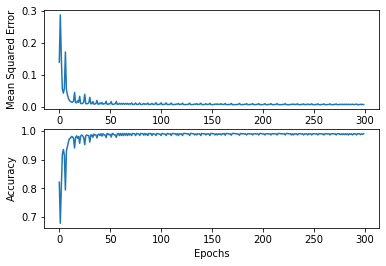

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.3388170438000466
Classification Report
                             
TP                        178
TN                        228
FP                          4
FN                          1
Total                     411
Accuracy   0.9878345498783455
Recall      0.994413407821229
Precision   0.978021978021978


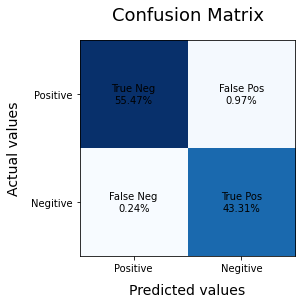

Split 5 : 
Training the Model...


Epoch: 0 Loss: 0.050764119488490085 Accuracy: 0.928125
Epoch: 50 Loss: 0.008575324746122152 Accuracy: 0.9916666666666667
Epoch: 100 Loss: 0.006643555077412123 Accuracy: 0.99375
Epoch: 150 Loss: 0.00604585044591185 Accuracy: 0.99375
Epoch: 200 Loss: 0.005727628833521155 Accuracy: 0.99375
Epoch: 250 Loss: 0.005527207358088443 Accuracy: 0.99375



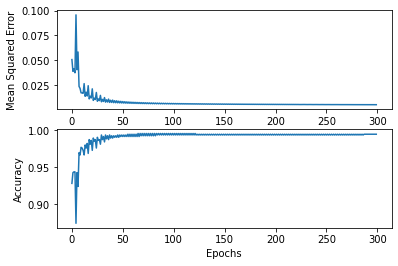

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.39726829488789034
Classification Report
                             
TP                        168
TN                        237
FP                          6
FN                          0
Total                     411
Accuracy   0.9854014598540146
Recall                    1.0
Precision  0.9655172413793104


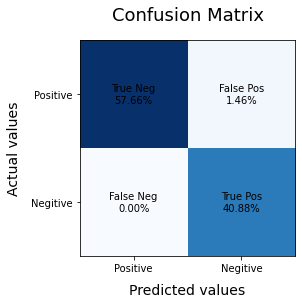

Split 6 : 
Training the Model...


Epoch: 0 Loss: 0.3470556024818297 Accuracy: 0.6291666666666667
Epoch: 50 Loss: 0.0073502317207365855 Accuracy: 0.9927083333333333
Epoch: 100 Loss: 0.006649214002574221 Accuracy: 0.99375
Epoch: 150 Loss: 0.006821979704223891 Accuracy: 0.9916666666666667
Epoch: 200 Loss: 0.0064026610474042355 Accuracy: 0.9927083333333333
Epoch: 250 Loss: 0.006327620013888559 Accuracy: 0.9927083333333333



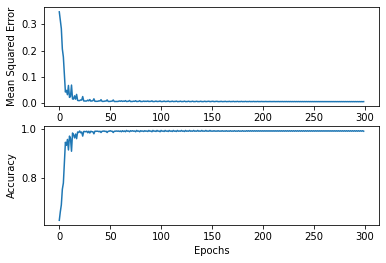

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.3659813612425676
Classification Report
                             
TP                        182
TN                        223
FP                          5
FN                          1
Total                     411
Accuracy   0.9854014598540146
Recall      0.994535519125683
Precision  0.9732620320855615


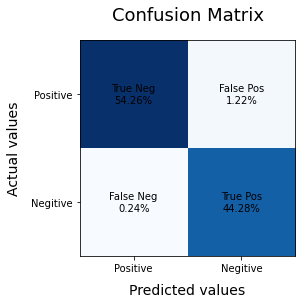

Split 7 : 
Training the Model...


Epoch: 0 Loss: 0.6255504493310713 Accuracy: 0.3072916666666667
Epoch: 50 Loss: 0.008453053065635464 Accuracy: 0.9875
Epoch: 100 Loss: 0.00932672408558354 Accuracy: 0.990625
Epoch: 150 Loss: 0.007641571948679981 Accuracy: 0.9895833333333334
Epoch: 200 Loss: 0.008881778031899025 Accuracy: 0.9864583333333333
Epoch: 250 Loss: 0.0099948610152949 Accuracy: 0.9854166666666667



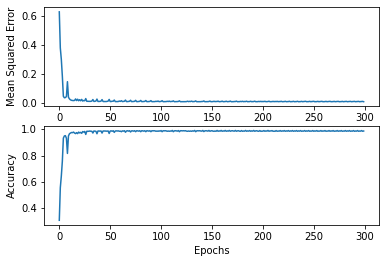

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.12959913842822957
Classification Report
                             
TP                        172
TN                        236
FP                          2
FN                          1
Total                     411
Accuracy   0.9927007299270073
Recall     0.9942196531791907
Precision  0.9885057471264368


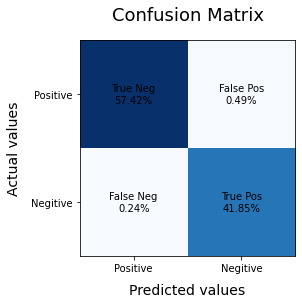

Split 8 : 
Training the Model...


Epoch: 0 Loss: 0.4147068934728028 Accuracy: 0.5416666666666666
Epoch: 50 Loss: 0.010395371764515856 Accuracy: 0.9875
Epoch: 100 Loss: 0.007148983836979275 Accuracy: 0.990625
Epoch: 150 Loss: 0.006964726519006242 Accuracy: 0.990625
Epoch: 200 Loss: 0.0063943515075854255 Accuracy: 0.990625
Epoch: 250 Loss: 0.0059669767170658075 Accuracy: 0.990625



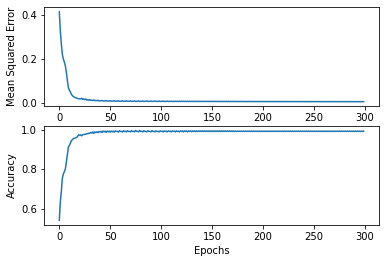

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.19613716233590656
Classification Report
                             
TP                        178
TN                        222
FP                          2
FN                          9
Total                     411
Accuracy   0.9732360097323601
Recall     0.9518716577540107
Precision  0.9888888888888889


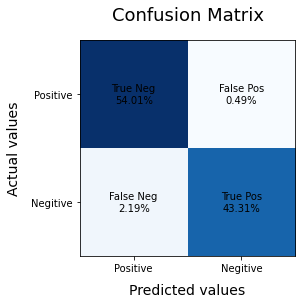

Split 9 : 
Training the Model...


Epoch: 0 Loss: 0.14770289859324276 Accuracy: 0.7885416666666667
Epoch: 50 Loss: 0.007441292153432404 Accuracy: 0.990625
Epoch: 100 Loss: 0.010734666346722434 Accuracy: 0.9854166666666667
Epoch: 150 Loss: 0.008210633023254282 Accuracy: 0.9885416666666667
Epoch: 200 Loss: 0.00613000207378628 Accuracy: 0.9895833333333334
Epoch: 250 Loss: 0.008250549918480463 Accuracy: 0.9885416666666667



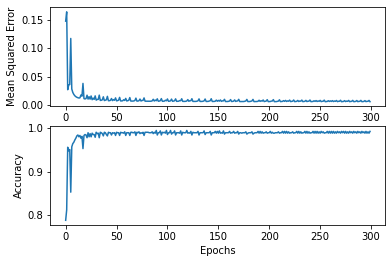

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.19525978734913638
Classification Report
                             
TP                        171
TN                        236
FP                          1
FN                          3
Total                     411
Accuracy   0.9902676399026764
Recall     0.9827586206896551
Precision  0.9941860465116279


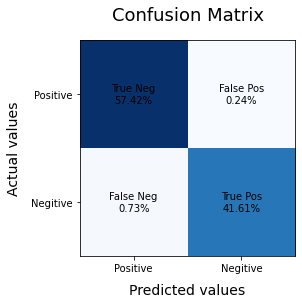

Split 10 : 
Training the Model...


Epoch: 0 Loss: 0.22899864672404385 Accuracy: 0.6833333333333333
Epoch: 50 Loss: 0.010893033682004442 Accuracy: 0.984375
Epoch: 100 Loss: 0.00845620427423879 Accuracy: 0.990625
Epoch: 150 Loss: 0.00937497340058659 Accuracy: 0.9864583333333333
Epoch: 200 Loss: 0.012339957382184689 Accuracy: 0.984375
Epoch: 250 Loss: 0.010684594047405472 Accuracy: 0.9864583333333333



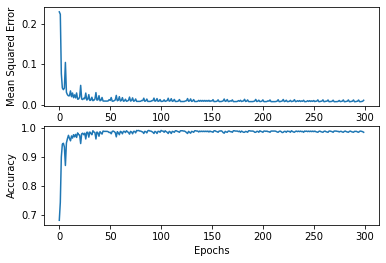

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.31903103797899024
Classification Report
                             
TP                        182
TN                        226
FP                          2
FN                          1
Total                     411
Accuracy   0.9927007299270073
Recall      0.994535519125683
Precision  0.9891304347826086


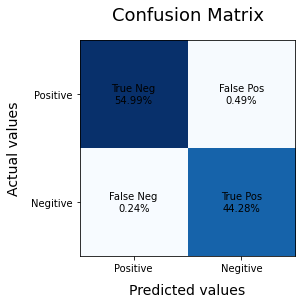

Final Classification Report
                             
TP                      176.1
TN                      229.9
FP                        3.1
FN                        1.9
Total                   411.0
Accuracy   0.9878345498783455
Recall     0.9895602835756728
Precision  0.9827388222303552


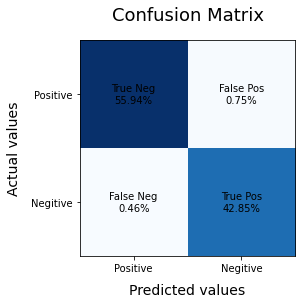

In [ ]:
GD.cross_val(10, epochs=300, learning_rate=0.015)

In [ ]:
# file = open(os.path.join(PARENT, 'GD_model_1.pickle'), 'wb')
# pickle.dump(sn, file)
# file.close()

In [ ]:
file = open(os.path.join(PARENT, 'GD_model_1.pickle'), 'rb')
GD = pickle.load(file)
file.close()

### Learning Rate =0.5 and Epochs = 500 - Accuracy = 99.02% - Standardized Data

In [10]:
GD1 = LogReg(df, standardize=True)

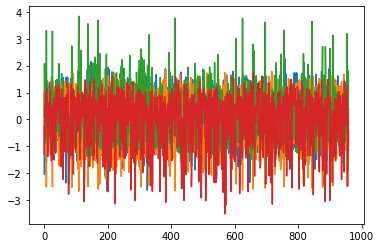

In [13]:
plt.plot(GD1.X_train)

Total of 10 Splits:
Split 1 : 
Training the Model...


Epoch: 0 Loss: 0.5073959691219728 Accuracy: 0.48854166666666665


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in exp


Epoch: 50 Loss: 0.040004330482168546 Accuracy: 0.9583333333333334
Epoch: 100 Loss: 0.020921343560371137 Accuracy: 0.978125
Epoch: 150 Loss: 0.008329654441652882 Accuracy: 0.9916666666666667
Epoch: 200 Loss: 0.011853378857123262 Accuracy: 0.9854166666666667
Epoch: 250 Loss: 0.013260766822312023 Accuracy: 0.9854166666666667
Epoch: 300 Loss: 0.02039874920595963 Accuracy: 0.9791666666666666
Epoch: 350 Loss: 0.0072960843022748835 Accuracy: 0.9927083333333333
Epoch: 400 Loss: 0.007293529068100048 Accuracy: 0.9927083333333333
Epoch: 450 Loss: 0.007292938526394834 Accuracy: 0.9927083333333333



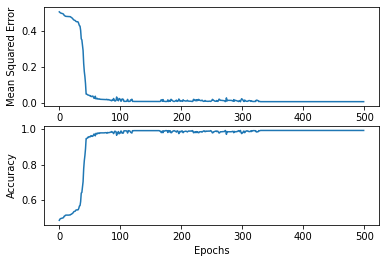

Trained the Model.
The most important feature is 'attr 3 ' with weight -4.968972744312339
Classification Report
                             
TP                        184
TN                        224
FP                          3
FN                          0
Total                     411
Accuracy   0.9927007299270073
Recall                    1.0
Precision   0.983957219251337


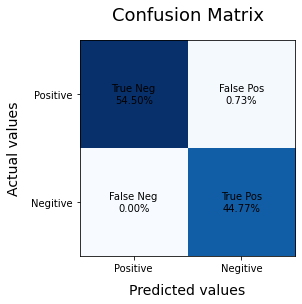

Split 2 : 
Training the Model...


Epoch: 0 Loss: 0.24589206810444247 Accuracy: 0.7510416666666667
Epoch: 50 Loss: 0.01865217361891852 Accuracy: 0.9802083333333333
Epoch: 100 Loss: 0.0062743686036883265 Accuracy: 0.99375
Epoch: 150 Loss: 0.006253645292823571 Accuracy: 0.99375
Epoch: 200 Loss: 0.006253302902227816 Accuracy: 0.99375
Epoch: 250 Loss: 0.006253148880383933 Accuracy: 0.99375
Epoch: 300 Loss: 0.006253023886028519 Accuracy: 0.99375
Epoch: 350 Loss: 0.006252912825613831 Accuracy: 0.99375
Epoch: 400 Loss: 0.006252812270149567 Accuracy: 0.99375
Epoch: 450 Loss: 0.006252720484234488 Accuracy: 0.99375



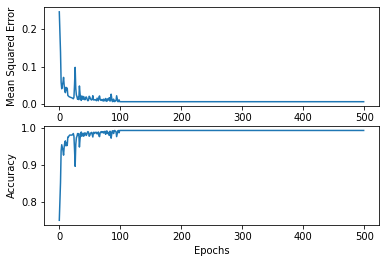

Trained the Model.
The most important feature is 'attr 3 ' with weight -4.164275313430843
Classification Report
                             
TP                        188
TN                        219
FP                          4
FN                          0
Total                     411
Accuracy   0.9902676399026764
Recall                    1.0
Precision  0.9791666666666666


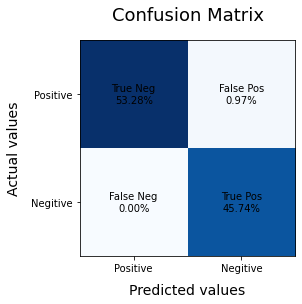

Split 3 : 
Training the Model...


Epoch: 0 Loss: 0.5143864897541288 Accuracy: 0.48541666666666666


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in exp


Epoch: 50 Loss: 0.026464465336181315 Accuracy: 0.9729166666666667
Epoch: 100 Loss: 0.022547280441991297 Accuracy: 0.9770833333333333
Epoch: 150 Loss: 0.014993801715909737 Accuracy: 0.9833333333333333
Epoch: 200 Loss: 0.009177190607120907 Accuracy: 0.990625
Epoch: 250 Loss: 0.020902999463156276 Accuracy: 0.9791666666666666
Epoch: 300 Loss: 0.009459685910018382 Accuracy: 0.9895833333333334
Epoch: 350 Loss: 0.017078032502035934 Accuracy: 0.98125
Epoch: 400 Loss: 0.007479660662063685 Accuracy: 0.9895833333333334
Epoch: 450 Loss: 0.008466830980144663 Accuracy: 0.9875



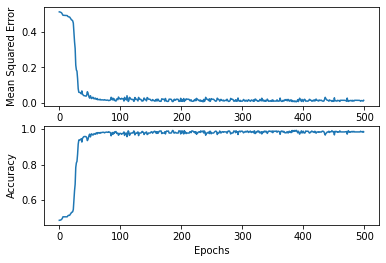

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.6914639974112418
Classification Report
                             
TP                        179
TN                        228
FP                          1
FN                          3
Total                     411
Accuracy   0.9902676399026764
Recall     0.9835164835164835
Precision  0.9944444444444445


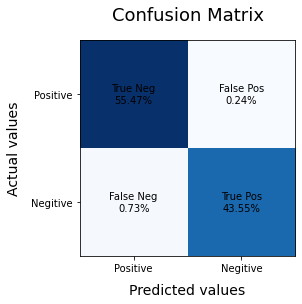

Split 4 : 
Training the Model...


Epoch: 0 Loss: 0.5192942344698188 Accuracy: 0.4791666666666667


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in exp


Epoch: 50 Loss: 0.04343490311891266 Accuracy: 0.95625
Epoch: 100 Loss: 0.009264185962200262 Accuracy: 0.990625
Epoch: 150 Loss: 0.007790207903189753 Accuracy: 0.990625
Epoch: 200 Loss: 0.008571569665615 Accuracy: 0.990625
Epoch: 250 Loss: 0.011119589043510968 Accuracy: 0.9875
Epoch: 300 Loss: 0.00607331511590208 Accuracy: 0.99375
Epoch: 350 Loss: 0.006236492032874134 Accuracy: 0.99375
Epoch: 400 Loss: 0.006228274781934569 Accuracy: 0.99375
Epoch: 450 Loss: 0.006240414277413532 Accuracy: 0.99375



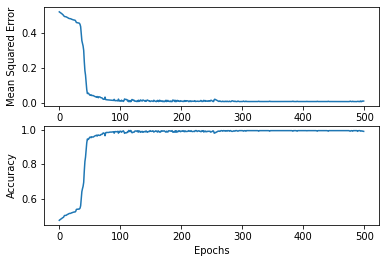

Trained the Model.
The most important feature is 'attr 3 ' with weight -2.4246301034125795
Classification Report
                             
TP                        183
TN                        222
FP                          4
FN                          2
Total                     411
Accuracy   0.9854014598540146
Recall     0.9891891891891892
Precision  0.9786096256684492


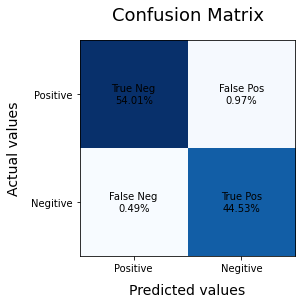

Split 5 : 
Training the Model...


Epoch: 0 Loss: 0.30885913561230904 Accuracy: 0.6885416666666667
Epoch: 50 Loss: 0.010766094650821033 Accuracy: 0.9875
Epoch: 100 Loss: 0.005218463631362596 Accuracy: 0.9947916666666666
Epoch: 150 Loss: 0.005213867833900417 Accuracy: 0.9947916666666666
Epoch: 200 Loss: 0.005212183336365687 Accuracy: 0.9947916666666666
Epoch: 250 Loss: 0.005211326852672964 Accuracy: 0.9947916666666666
Epoch: 300 Loss: 0.005210817109892307 Accuracy: 0.9947916666666666
Epoch: 350 Loss: 0.005210484043089078 Accuracy: 0.9947916666666666
Epoch: 400 Loss: 0.005210252464899793 Accuracy: 0.9947916666666666
Epoch: 450 Loss: 0.005210084079804776 Accuracy: 0.9947916666666666



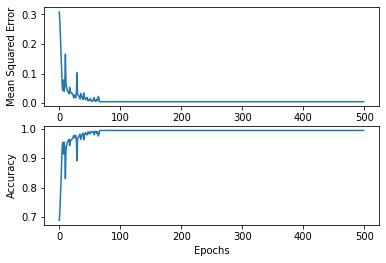

Trained the Model.
The most important feature is 'attr 3 ' with weight -4.3583141994136865
Classification Report
                             
TP                        186
TN                        220
FP                          5
FN                          0
Total                     411
Accuracy   0.9878345498783455
Recall                    1.0
Precision  0.9738219895287958


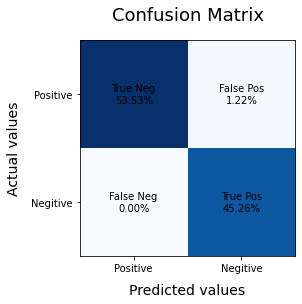

Split 6 : 
Training the Model...


Epoch: 0 Loss: 0.09098287466365022 Accuracy: 0.9
Epoch: 50 Loss: 0.020489997707597834 Accuracy: 0.9791666666666666
Epoch: 100 Loss: 0.016018576347355474 Accuracy: 0.9833333333333333
Epoch: 150 Loss: 0.008334848842877591 Accuracy: 0.9916666666666667
Epoch: 200 Loss: 0.008332401153701888 Accuracy: 0.9916666666666667
Epoch: 250 Loss: 0.008330736011951773 Accuracy: 0.9916666666666667
Epoch: 300 Loss: 0.008328103923552455 Accuracy: 0.9916666666666667
Epoch: 350 Loss: 0.008312895523219234 Accuracy: 0.9916666666666667
Epoch: 400 Loss: 0.011420973950519943 Accuracy: 0.9885416666666667
Epoch: 450 Loss: 0.008660207196753521 Accuracy: 0.990625



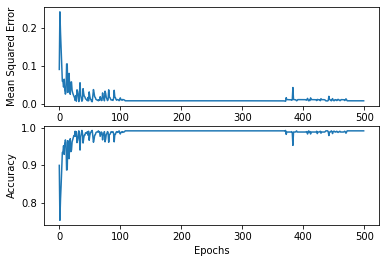

Trained the Model.
The most important feature is 'attr 3 ' with weight -3.012886103486996
Classification Report
                             
TP                        179
TN                        230
FP                          2
FN                          0
Total                     411
Accuracy   0.9951338199513382
Recall                    1.0
Precision   0.988950276243094


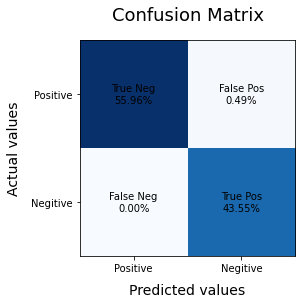

Split 7 : 
Training the Model...


Epoch: 0 Loss: 0.4941257975560196 Accuracy: 0.5041666666666667
Epoch: 50 Loss: 0.01836713548845451 Accuracy: 0.98125
Epoch: 100 Loss: 0.007301679071983868 Accuracy: 0.9927083333333333
Epoch: 150 Loss: 0.00729748526450497 Accuracy: 0.9927083333333333
Epoch: 200 Loss: 0.007295812506259214 Accuracy: 0.9927083333333333
Epoch: 250 Loss: 0.0072949233053204825 Accuracy: 0.9927083333333333
Epoch: 300 Loss: 0.007294380062875087 Accuracy: 0.9927083333333333
Epoch: 350 Loss: 0.0072940190464775385 Accuracy: 0.9927083333333333
Epoch: 400 Loss: 0.00729376527266221 Accuracy: 0.9927083333333333
Epoch: 450 Loss: 0.007293579600923874 Accuracy: 0.9927083333333333



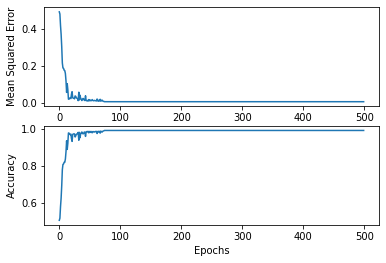

Trained the Model.
The most important feature is 'attr 3 ' with weight -4.758281158939313
Classification Report
                             
TP                        180
TN                        228
FP                          3
FN                          0
Total                     411
Accuracy   0.9927007299270073
Recall                    1.0
Precision  0.9836065573770492


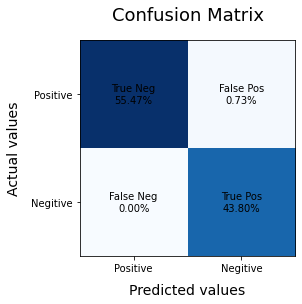

Split 8 : 
Training the Model...


Epoch: 0 Loss: 0.46842129655092474 Accuracy: 0.5302083333333333
Epoch: 50 Loss: 0.016038027365471642 Accuracy: 0.9833333333333333
Epoch: 100 Loss: 0.006257454653155946 Accuracy: 0.99375
Epoch: 150 Loss: 0.006253434030838345 Accuracy: 0.99375
Epoch: 200 Loss: 0.006252738486838886 Accuracy: 0.99375
Epoch: 250 Loss: 0.006252276580843332 Accuracy: 0.99375
Epoch: 300 Loss: 0.006251947166310585 Accuracy: 0.99375
Epoch: 350 Loss: 0.006251700805516752 Accuracy: 0.99375
Epoch: 400 Loss: 0.006251509857835758 Accuracy: 0.99375
Epoch: 450 Loss: 0.006251357682093705 Accuracy: 0.99375



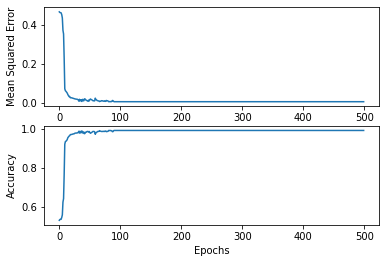

Trained the Model.
The most important feature is 'attr 3 ' with weight -4.639230863202216
Classification Report
                             
TP                        176
TN                        230
FP                          4
FN                          1
Total                     411
Accuracy   0.9878345498783455
Recall     0.9943502824858758
Precision  0.9777777777777777


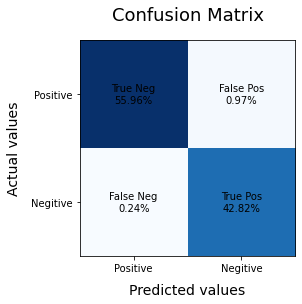

Split 9 : 
Training the Model...


Epoch: 0 Loss: 0.09451349777339317 Accuracy: 0.896875
Epoch: 50 Loss: 0.012727251441264336 Accuracy: 0.9875
Epoch: 100 Loss: 0.005221980899096801 Accuracy: 0.9947916666666666
Epoch: 150 Loss: 0.00521931695354571 Accuracy: 0.9947916666666666
Epoch: 200 Loss: 0.005217943010991336 Accuracy: 0.9947916666666666
Epoch: 250 Loss: 0.0052169785430368635 Accuracy: 0.9947916666666666
Epoch: 300 Loss: 0.005216250018874828 Accuracy: 0.9947916666666666
Epoch: 350 Loss: 0.00521568850098303 Accuracy: 0.9947916666666666
Epoch: 400 Loss: 0.005215253681489314 Accuracy: 0.9947916666666666
Epoch: 450 Loss: 0.00521491751350014 Accuracy: 0.9947916666666666



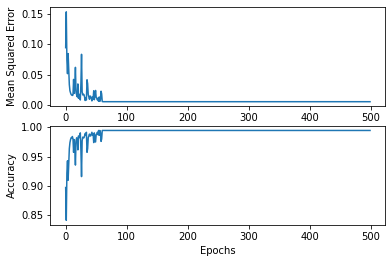

Trained the Model.
The most important feature is 'attr 3 ' with weight -4.305826002982822
Classification Report
                             
TP                        197
TN                        209
FP                          5
FN                          0
Total                     411
Accuracy   0.9878345498783455
Recall                    1.0
Precision  0.9752475247524752


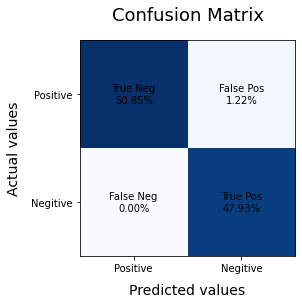

Split 10 : 
Training the Model...


Epoch: 0 Loss: 0.4978638503587875 Accuracy: 0.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in exp


Epoch: 50 Loss: 0.029810596328198876 Accuracy: 0.9697916666666667
Epoch: 100 Loss: 0.006563412451819818 Accuracy: 0.9927083333333333
Epoch: 150 Loss: 0.01425335138299355 Accuracy: 0.9854166666666667
Epoch: 200 Loss: 0.016162104762458374 Accuracy: 0.9822916666666667
Epoch: 250 Loss: 0.007236289114447307 Accuracy: 0.9927083333333333
Epoch: 300 Loss: 0.018006357945391963 Accuracy: 0.9822916666666667
Epoch: 350 Loss: 0.017740157940498515 Accuracy: 0.98125
Epoch: 400 Loss: 0.01135670274159061 Accuracy: 0.9885416666666667
Epoch: 450 Loss: 0.008341382332927284 Accuracy: 0.9916666666666667



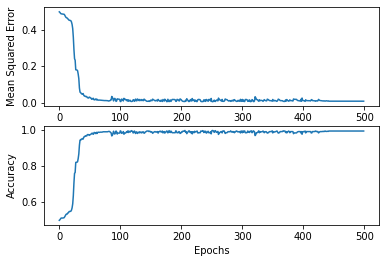

Trained the Model.
The most important feature is 'attr 3 ' with weight -4.978720323749019
Classification Report
                             
TP                        168
TN                        240
FP                          2
FN                          1
Total                     411
Accuracy   0.9927007299270073
Recall     0.9940828402366864
Precision  0.9882352941176471


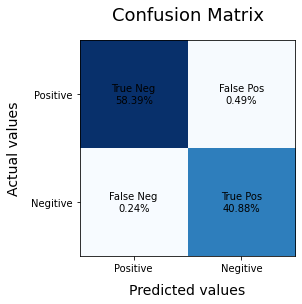

Final Classification Report
                             
TP                      182.0
TN                      225.0
FP                        3.3
FN                        0.7
Total                   411.0
Accuracy   0.9902676399026763
Recall     0.9961138795428234
Precision  0.9823817375827737


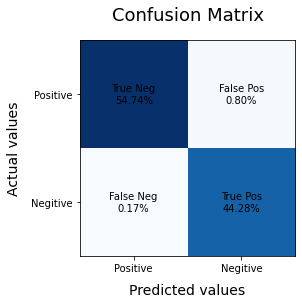

In [14]:
GD1.cross_val(10, epochs=500, learning_rate=0.5)

### Learning Rate = 0.1 and Epochs = 200 - Accuracy = 98.90% - Standardized

In [16]:
GD3 = LogReg(df, standardize=True)

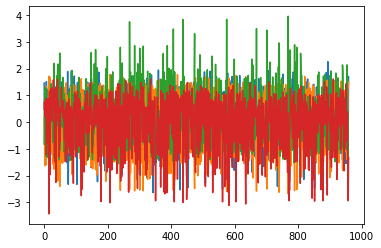

In [19]:
plt.plot(GD3.X_train)

Total of 10 Splits:
Split 1 : 
Training the Model...


Epoch: 0 Loss: 0.33459108542642724 Accuracy: 0.6645833333333333
Epoch: 50 Loss: 0.23494796300331414 Accuracy: 0.759375
Epoch: 100 Loss: 0.017718942342051076 Accuracy: 0.9802083333333333
Epoch: 150 Loss: 0.00899517236336831 Accuracy: 0.9885416666666667



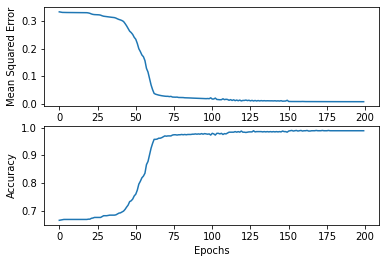

Trained the Model.
The most important feature is 'attr 3 ' with weight -1.6777459496790401
Classification Report
                             
TP                        178
TN                        230
FP                          3
FN                          0
Total                     411
Accuracy   0.9927007299270073
Recall                    1.0
Precision  0.9834254143646409


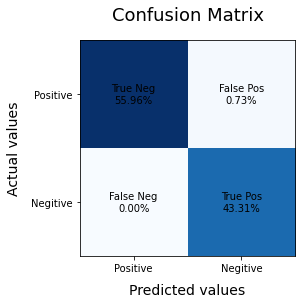

Split 2 : 
Training the Model...


Epoch: 0 Loss: 0.3128549273251283 Accuracy: 0.6854166666666667
Epoch: 50 Loss: 0.010079662716841142 Accuracy: 0.984375
Epoch: 100 Loss: 0.006043824099515325 Accuracy: 0.9916666666666667
Epoch: 150 Loss: 0.015606887213365379 Accuracy: 0.9822916666666667



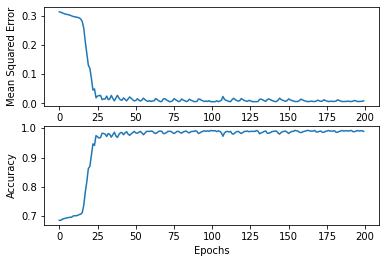

Trained the Model.
The most important feature is 'attr 3 ' with weight -1.0441924297864693
Classification Report
                             
TP                        176
TN                        229
FP                          4
FN                          2
Total                     411
Accuracy   0.9854014598540146
Recall     0.9887640449438202
Precision  0.9777777777777777


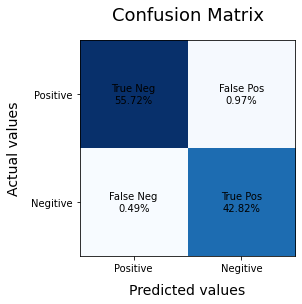

Split 3 : 
Training the Model...


Epoch: 0 Loss: 0.5119227523145313 Accuracy: 0.4822916666666667
Epoch: 50 Loss: 0.020356262339052873 Accuracy: 0.9791666666666666
Epoch: 100 Loss: 0.007721335007908477 Accuracy: 0.9927083333333333
Epoch: 150 Loss: 0.007458471789965051 Accuracy: 0.9927083333333333



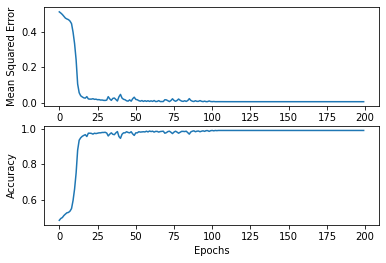

Trained the Model.
The most important feature is 'attr 3 ' with weight -1.900128863431843
Classification Report
                             
TP                        192
TN                        216
FP                          3
FN                          0
Total                     411
Accuracy   0.9927007299270073
Recall                    1.0
Precision  0.9846153846153847


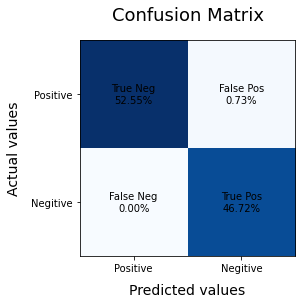

Split 4 : 
Training the Model...


Epoch: 0 Loss: 0.2683756447372539 Accuracy: 0.728125
Epoch: 50 Loss: 0.01920520001797393 Accuracy: 0.9770833333333333
Epoch: 100 Loss: 0.010911014411373618 Accuracy: 0.9864583333333333
Epoch: 150 Loss: 0.00652854867458703 Accuracy: 0.9927083333333333



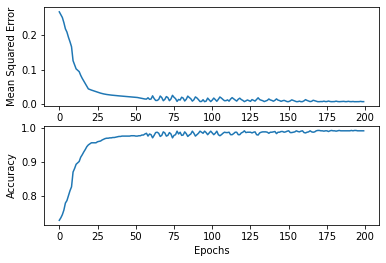

Trained the Model.
The most important feature is 'attr 3 ' with weight -1.6782811976998002
Classification Report
                             
TP                        191
TN                        214
FP                          4
FN                          2
Total                     411
Accuracy   0.9854014598540146
Recall     0.9896373056994818
Precision  0.9794871794871794


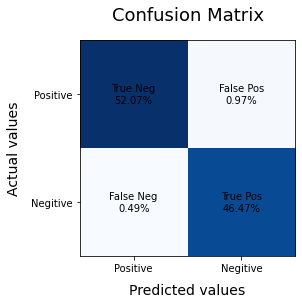

Split 5 : 
Training the Model...


Epoch: 0 Loss: 0.23932471856641485 Accuracy: 0.7427083333333333
Epoch: 50 Loss: 0.013456309587093259 Accuracy: 0.9854166666666667
Epoch: 100 Loss: 0.01394676940336311 Accuracy: 0.9854166666666667
Epoch: 150 Loss: 0.008265876756847486 Accuracy: 0.990625



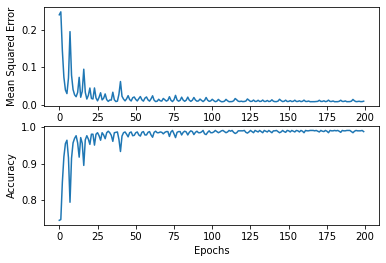

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.8267339660473938
Classification Report
                             
TP                        181
TN                        226
FP                          3
FN                          1
Total                     411
Accuracy   0.9902676399026764
Recall     0.9945054945054945
Precision  0.9836956521739131


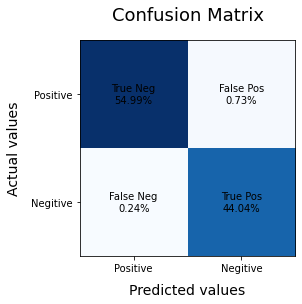

Split 6 : 
Training the Model...


Epoch: 0 Loss: 0.10480184941941391 Accuracy: 0.88125
Epoch: 50 Loss: 0.014176089118699697 Accuracy: 0.9802083333333333
Epoch: 100 Loss: 0.008693715977447931 Accuracy: 0.9885416666666667
Epoch: 150 Loss: 0.017347947681058462 Accuracy: 0.9802083333333333



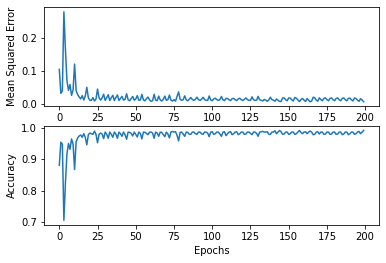

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.5315766901064014
Classification Report
                             
TP                        173
TN                        234
FP                          0
FN                          4
Total                     411
Accuracy   0.9902676399026764
Recall     0.9774011299435028
Precision                 1.0


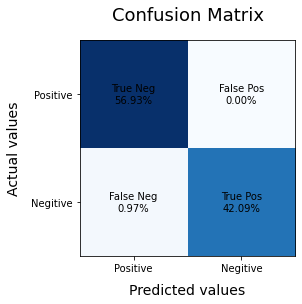

Split 7 : 
Training the Model...


Epoch: 0 Loss: 0.12710568150467125 Accuracy: 0.85
Epoch: 50 Loss: 0.004604116846823736 Accuracy: 0.9958333333333333
Epoch: 100 Loss: 0.0059956258291697425 Accuracy: 0.99375
Epoch: 150 Loss: 0.0045463333033126715 Accuracy: 0.9958333333333333



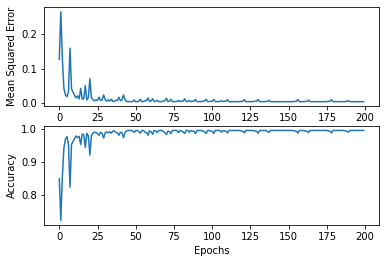

Trained the Model.
The most important feature is 'attr 3 ' with weight -1.7235488878692222
Classification Report
                             
TP                        177
TN                        228
FP                          6
FN                          0
Total                     411
Accuracy   0.9854014598540146
Recall                    1.0
Precision  0.9672131147540983


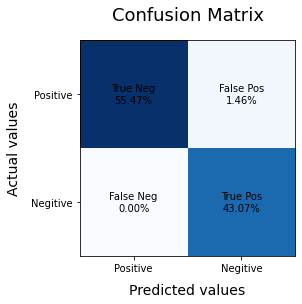

Split 8 : 
Training the Model...


Epoch: 0 Loss: 0.4781261098433564 Accuracy: 0.5125
Epoch: 50 Loss: 0.009756268069191849 Accuracy: 0.9885416666666667
Epoch: 100 Loss: 0.009520331729828718 Accuracy: 0.9895833333333334
Epoch: 150 Loss: 0.010082893516458417 Accuracy: 0.9875



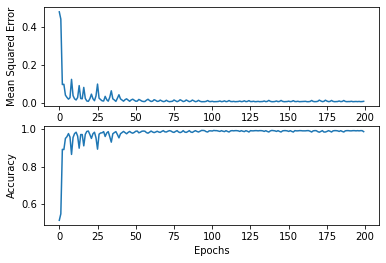

Trained the Model.
The most important feature is 'attr 3 ' with weight -1.043653268504383
Classification Report
                             
TP                        189
TN                        217
FP                          3
FN                          2
Total                     411
Accuracy   0.9878345498783455
Recall     0.9895287958115183
Precision            0.984375


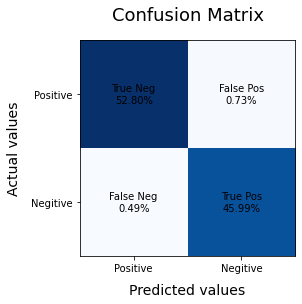

Split 9 : 
Training the Model...


Epoch: 0 Loss: 0.2773292856456279 Accuracy: 0.703125
Epoch: 50 Loss: 0.017088960962893897 Accuracy: 0.98125
Epoch: 100 Loss: 0.010491055813459467 Accuracy: 0.9885416666666667
Epoch: 150 Loss: 0.00929241839995206 Accuracy: 0.9885416666666667



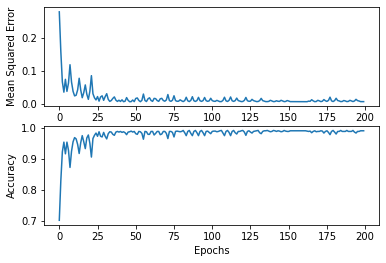

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.7980865362485733
Classification Report
                             
TP                        194
TN                        214
FP                          3
FN                          0
Total                     411
Accuracy   0.9927007299270073
Recall                    1.0
Precision  0.9847715736040609


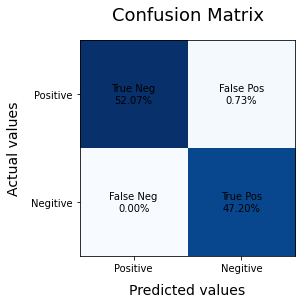

Split 10 : 
Training the Model...


Epoch: 0 Loss: 0.22669423613819892 Accuracy: 0.765625
Epoch: 50 Loss: 0.012314730041143094 Accuracy: 0.9875
Epoch: 100 Loss: 0.012108056165498822 Accuracy: 0.9854166666666667
Epoch: 150 Loss: 0.00881689478676959 Accuracy: 0.990625



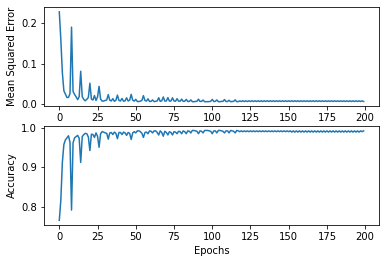

Trained the Model.
The most important feature is 'attr 3 ' with weight -1.270233451399583
Classification Report
                             
TP                        168
TN                        238
FP                          4
FN                          1
Total                     411
Accuracy   0.9878345498783455
Recall     0.9940828402366864
Precision  0.9767441860465116


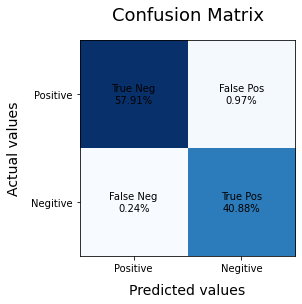

Final Classification Report
                             
TP                      181.9
TN                      224.6
FP                        3.3
FN                        1.2
Total                   411.0
Accuracy   0.9890510948905108
Recall     0.9933919611140503
Precision  0.9822105282823566


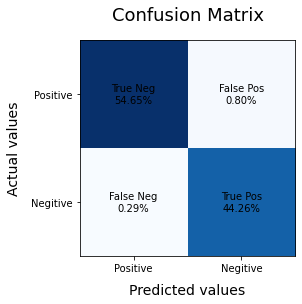

In [23]:
GD3.cross_val(10, epochs=200, learning_rate=0.1)

## Stochastic Gradient Descent

In [ ]:
SGD = LogReg(df)

Total of 10 Splits:
Split 1 : 
Training the Model...


Epoch: 0 Loss: 0.2823450523497489 Accuracy: 0.696875
Epoch: 50 Loss: 0.010637690140664706 Accuracy: 0.9864583333333333
Epoch: 100 Loss: 0.014266884028927507 Accuracy: 0.9791666666666666
Epoch: 150 Loss: 0.006734971702622963 Accuracy: 0.9916666666666667
Epoch: 200 Loss: 0.013253989032632519 Accuracy: 0.984375
Epoch: 250 Loss: 0.006445083517443668 Accuracy: 0.9895833333333334



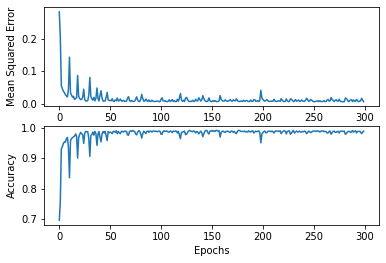

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.5606612013758543
Classification Report
                             
TP                        184
TN                        222
FP                          3
FN                          2
Total                     411
Accuracy   0.9878345498783455
Recall      0.989247311827957
Precision   0.983957219251337


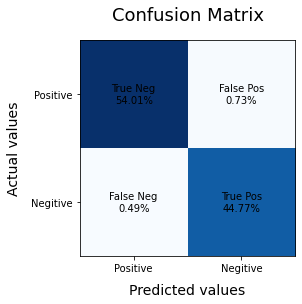

Split 2 : 
Training the Model...


Epoch: 0 Loss: 0.3257494313410974 Accuracy: 0.6520833333333333
Epoch: 50 Loss: 0.014344524435147173 Accuracy: 0.98125
Epoch: 100 Loss: 0.009589312812076345 Accuracy: 0.9885416666666667
Epoch: 150 Loss: 0.008779840773684587 Accuracy: 0.9885416666666667
Epoch: 200 Loss: 0.00921176620788813 Accuracy: 0.9885416666666667
Epoch: 250 Loss: 0.010691732624313648 Accuracy: 0.9854166666666667



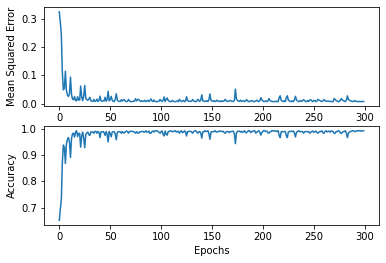

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.7370581864590212
Classification Report
                             
TP                        177
TN                        230
FP                          3
FN                          1
Total                     411
Accuracy   0.9902676399026764
Recall     0.9943820224719101
Precision  0.9833333333333333


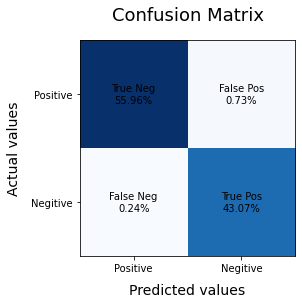

Split 3 : 
Training the Model...


Epoch: 0 Loss: 0.3047194172619766 Accuracy: 0.678125
Epoch: 50 Loss: 0.01081504890433253 Accuracy: 0.9864583333333333
Epoch: 100 Loss: 0.0053817802215886225 Accuracy: 0.9958333333333333
Epoch: 150 Loss: 0.0063047839663821085 Accuracy: 0.9947916666666666
Epoch: 200 Loss: 0.005204068156399676 Accuracy: 0.9958333333333333
Epoch: 250 Loss: 0.005365465119461361 Accuracy: 0.9958333333333333



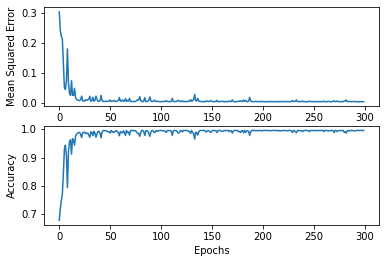

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.9123238958691652
Classification Report
                             
TP                        170
TN                        235
FP                          6
FN                          0
Total                     411
Accuracy   0.9854014598540146
Recall                    1.0
Precision  0.9659090909090909


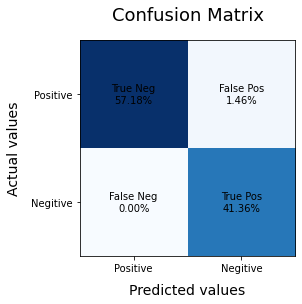

Split 4 : 
Training the Model...


Epoch: 0 Loss: 0.2683796571396936 Accuracy: 0.684375
Epoch: 50 Loss: 0.006130565391169567 Accuracy: 0.9927083333333333
Epoch: 100 Loss: 0.010201355573269925 Accuracy: 0.9885416666666667
Epoch: 150 Loss: 0.007064820491648172 Accuracy: 0.990625
Epoch: 200 Loss: 0.006901226489881225 Accuracy: 0.990625
Epoch: 250 Loss: 0.013355436068683103 Accuracy: 0.98125



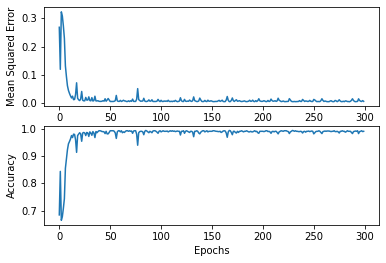

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.4644182331193705
Classification Report
                             
TP                        177
TN                        227
FP                          4
FN                          3
Total                     411
Accuracy   0.9829683698296837
Recall     0.9833333333333333
Precision  0.9779005524861878


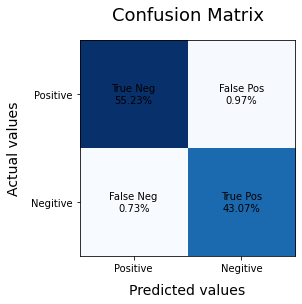

Split 5 : 
Training the Model...


Epoch: 0 Loss: 0.1834753144985736 Accuracy: 0.7947916666666667
Epoch: 50 Loss: 0.012861831221259761 Accuracy: 0.984375
Epoch: 100 Loss: 0.007197917036058722 Accuracy: 0.9895833333333334
Epoch: 150 Loss: 0.012467928121468063 Accuracy: 0.9854166666666667
Epoch: 200 Loss: 0.013795224057290167 Accuracy: 0.98125
Epoch: 250 Loss: 0.005930107602259817 Accuracy: 0.9895833333333334



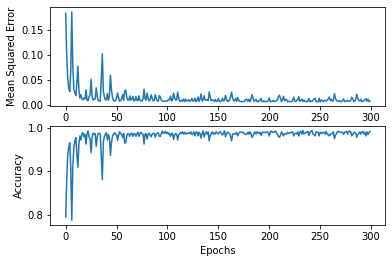

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.2527342504231424
Classification Report
                             
TP                        194
TN                        206
FP                          2
FN                          9
Total                     411
Accuracy   0.9732360097323601
Recall     0.9556650246305419
Precision  0.9897959183673469


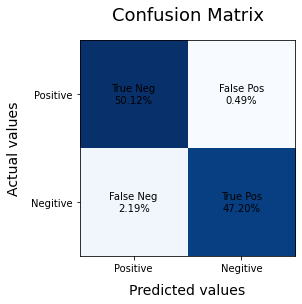

Split 6 : 
Training the Model...


Epoch: 0 Loss: 0.36653819433666723 Accuracy: 0.625
Epoch: 50 Loss: 0.013565416237925737 Accuracy: 0.9822916666666667
Epoch: 100 Loss: 0.006549417044823338 Accuracy: 0.9927083333333333
Epoch: 150 Loss: 0.012097082699156879 Accuracy: 0.9864583333333333
Epoch: 200 Loss: 0.006861232314046484 Accuracy: 0.990625
Epoch: 250 Loss: 0.016965029126405025 Accuracy: 0.98125



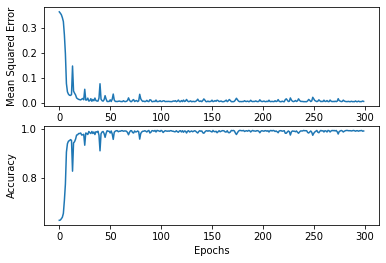

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.6130738867976359
Classification Report
                             
TP                        180
TN                        225
FP                          4
FN                          2
Total                     411
Accuracy   0.9854014598540146
Recall      0.989010989010989
Precision  0.9782608695652174


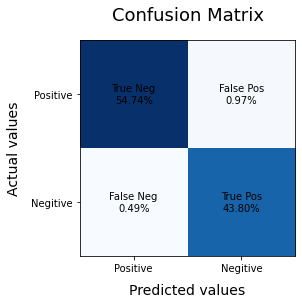

Split 7 : 
Training the Model...


Epoch: 0 Loss: 0.3445923076443476 Accuracy: 0.6447916666666667
Epoch: 50 Loss: 0.013453328110912677 Accuracy: 0.978125
Epoch: 100 Loss: 0.008386618270238665 Accuracy: 0.984375
Epoch: 150 Loss: 0.009349172209107541 Accuracy: 0.9864583333333333
Epoch: 200 Loss: 0.015191414195923387 Accuracy: 0.9833333333333333
Epoch: 250 Loss: 0.010253009562612053 Accuracy: 0.9833333333333333



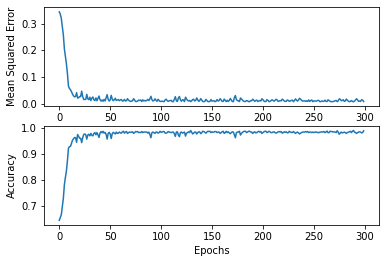

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.27772240630437045
Classification Report
                             
TP                        183
TN                        225
FP                          1
FN                          2
Total                     411
Accuracy   0.9927007299270073
Recall     0.9891891891891892
Precision  0.9945652173913043


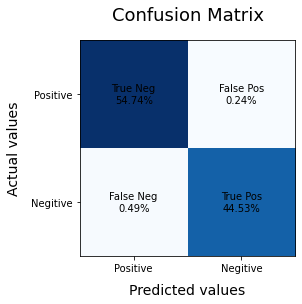

Split 8 : 
Training the Model...


Epoch: 0 Loss: 0.2988359895062032 Accuracy: 0.6885416666666667
Epoch: 50 Loss: 0.016280681973310174 Accuracy: 0.9791666666666666
Epoch: 100 Loss: 0.015420889445811261 Accuracy: 0.98125
Epoch: 150 Loss: 0.011717135246412998 Accuracy: 0.9864583333333333
Epoch: 200 Loss: 0.007890449001379392 Accuracy: 0.9895833333333334
Epoch: 250 Loss: 0.014570238896841248 Accuracy: 0.98125



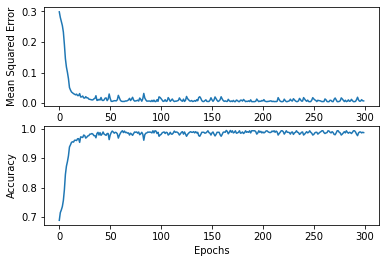

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.5286282534651549
Classification Report
                             
TP                        200
TN                        205
FP                          2
FN                          4
Total                     411
Accuracy   0.9854014598540146
Recall     0.9803921568627451
Precision  0.9900990099009901


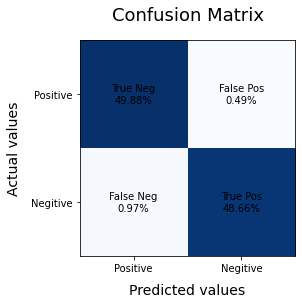

Split 9 : 
Training the Model...


Epoch: 0 Loss: 0.1308283651522367 Accuracy: 0.825
Epoch: 50 Loss: 0.011353463331025786 Accuracy: 0.9854166666666667
Epoch: 100 Loss: 0.006387804749412042 Accuracy: 0.990625
Epoch: 150 Loss: 0.007014808627115692 Accuracy: 0.990625
Epoch: 200 Loss: 0.008932550454581939 Accuracy: 0.9895833333333334
Epoch: 250 Loss: 0.006146427457118951 Accuracy: 0.99375



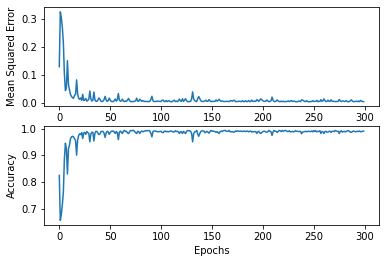

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.5359629265898525
Classification Report
                             
TP                        196
TN                        210
FP                          4
FN                          1
Total                     411
Accuracy   0.9878345498783455
Recall     0.9949238578680203
Precision                0.98


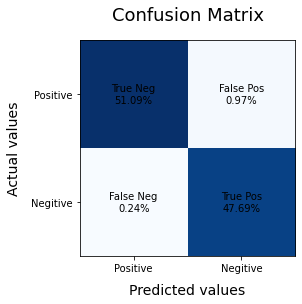

Split 10 : 
Training the Model...


Epoch: 0 Loss: 0.2597097066944307 Accuracy: 0.7291666666666666
Epoch: 50 Loss: 0.009360623838140677 Accuracy: 0.9822916666666667
Epoch: 100 Loss: 0.00880690971171374 Accuracy: 0.9875
Epoch: 150 Loss: 0.01310584328210999 Accuracy: 0.9833333333333333
Epoch: 200 Loss: 0.008519816181366211 Accuracy: 0.984375
Epoch: 250 Loss: 0.009337712554963825 Accuracy: 0.984375



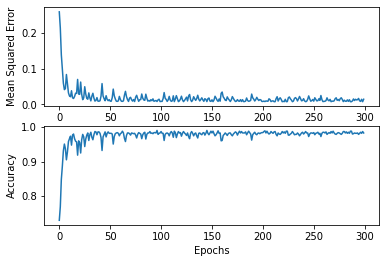

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.3098313105768754
Classification Report
                             
TP                        170
TN                        235
FP                          1
FN                          5
Total                     411
Accuracy   0.9854014598540146
Recall     0.9714285714285714
Precision  0.9941520467836257


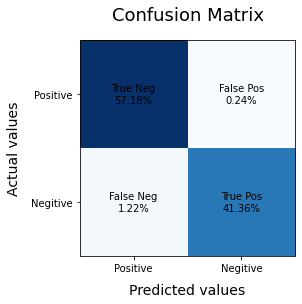

Final Classification Report
                             
TP                      183.1
TN                      222.0
FP                        3.0
FN                        2.9
Total                   411.0
Accuracy   0.9856447688564476
Recall     0.9847572456623258
Precision  0.9837973257988434


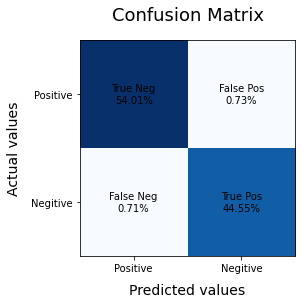

In [ ]:
SGD.cross_val(10, learning='SGD', epochs=300, learning_rate=0.03)

In [ ]:
# file = open(os.path.join(PARENT, 'SGD_model_2.pickle'), 'wb')
# pickle.dump(SGD, file)
# file.close()

In [ ]:
file = open(os.path.join(PARENT, 'SGD_model_2.pickle'), 'rb')
SGD = pickle.load(file)
file.close()